# Train a Simple TensorFlow Lite for Microcontrollers model

This notebook demonstrates the process of training a 2.5 kB model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers. 

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.

The model created in this notebook is used in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Configure Defaults

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [2]:
! pip install tensorflow==2.2.1

Import Dependencies

In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
import datetime
import seaborn as sns


# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

### 1. Generate Data

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph.

       HourlyDryBulbTemperature
0                          40.0
1                          39.0
2                          39.0
3                          39.0
4                          39.0
...                         ...
68814                      64.0
68815                      62.0
68816                      61.0
68817                      60.0
68818                      59.0

[68819 rows x 1 columns]
Index(['HourlyDryBulbTemperature'], dtype='object')


<ipython-input-6-8b908c4a5094>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HourlyDryBulbTemperature'] = df['HourlyDryBulbTemperature'].astype(np.float32)


array([<AxesSubplot:>], dtype=object)

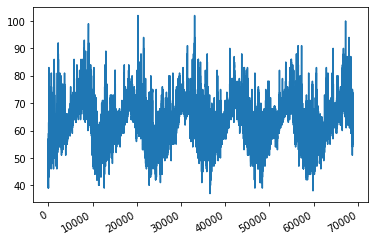

In [6]:
t = pd.read_csv('/home/mrrumpf/build/planb/vscode-template-linux/2338365-no-nans.csv')
df = t[['DATE','HourlyDryBulbTemperature']]
df['HourlyDryBulbTemperature'] = df['HourlyDryBulbTemperature'].astype(np.float32)

date_time = pd.to_datetime(df.pop('DATE'), format='%Y-%m-%d %H:%M:%S')

print(df)
print(df.columns)

#X=np.asarray(X).astype(np.float32)

uni_data = df['HourlyDryBulbTemperature']
uni_data.head()
uni_data.plot(subplots=True)

<ipython-input-10-6c8fbded792f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
<ipython-input-10-6c8fbded792f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))


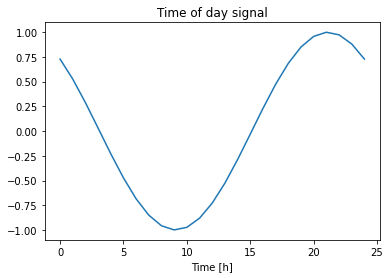

In [10]:
# Handle time periodicy

timestamp_s = date_time.map(datetime.datetime.timestamp)
#y_values = timestamp_s

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

plt.plot(np.array(df['Day sin'])[:25])
#plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

x_values = uni_data
y_values = df['Day sin']

### 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 

The following code will split our data and then plots each set as a different color:


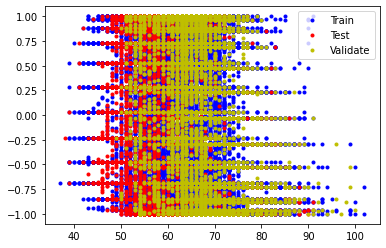

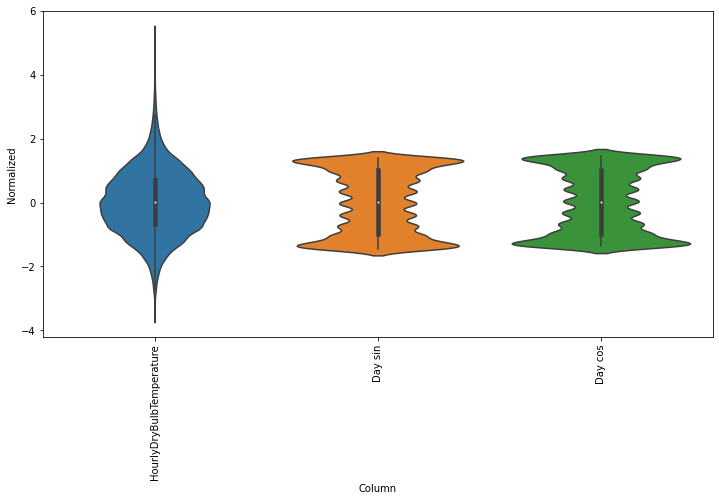

In [15]:
SAMPLES = df['HourlyDryBulbTemperature'].count()

# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.8 * SAMPLES)
TEST_SPLIT = int(0.1 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

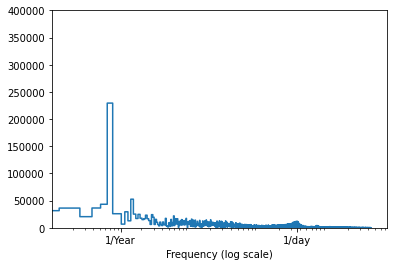

In [16]:
fft = tf.signal.rfft(df['HourlyDryBulbTemperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['HourlyDryBulbTemperature'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Training

### 1. Design the Model
We're going to build a simple neural network model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a _regression_. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 8 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

**Note:** To learn more about how neural networks function, you can explore the [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) codelabs.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [17]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))
2178927893847998464.0000
# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

### 2. Train the Model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 500 _epochs_, with 64 pieces of data in each _batch_. We also pass in some data for _validation_. As you will see when you run the cell, training can take a while to complete:



In [18]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=64,
                        validation_data=(x_validate, y_validate))

Epoch 1/500
861/861 [==============================] - 1s 967us/step - loss: 9.4069 - mae: 1.4959 - val_loss: 0.4848 - val_mae: 0.6246
Epoch 2/500
861/861 [==============================] - 1s 923us/step - loss: 0.4912 - mae: 0.6294 - val_loss: 0.4844 - val_mae: 0.6241
Epoch 3/500
861/861 [==============================] - 1s 863us/step - loss: 0.4908 - mae: 0.6292 - val_loss: 0.4831 - val_mae: 0.6233
Epoch 4/500
861/861 [==============================] - 1s 886us/step - loss: 0.4899 - mae: 0.6287 - val_loss: 0.4831 - val_mae: 0.6232
Epoch 5/500
861/861 [==============================] - 1s 898us/step - loss: 0.4885 - mae: 0.6277 - val_loss: 0.4800 - val_mae: 0.6212
Epoch 6/500
861/861 [==============================] - 1s 817us/step - loss: 0.4870 - mae: 0.6266 - val_loss: 0.4767 - val_mae: 0.6189
Epoch 7/500
861/861 [==============================] - 1s 921us/step - loss: 0.4848 - mae: 0.6244 - val_loss: 0.4714 - val_mae: 0.6157
Epoch 8/500
861/861 [==============================] - 

Epoch 62/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4763 - mae: 0.6130 - val_loss: 0.4553 - val_mae: 0.6025
Epoch 63/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4751 - mae: 0.6123 - val_loss: 0.4708 - val_mae: 0.6065
Epoch 64/500
861/861 [==============================] - 1s 681us/step - loss: 0.4747 - mae: 0.6122 - val_loss: 0.4601 - val_mae: 0.6032
Epoch 65/500
861/861 [==============================] - 1s 845us/step - loss: 0.4752 - mae: 0.6128 - val_loss: 0.4632 - val_mae: 0.6042
Epoch 66/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4759 - mae: 0.6128 - val_loss: 0.4823 - val_mae: 0.6101
Epoch 67/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4750 - mae: 0.6125 - val_loss: 0.4554 - val_mae: 0.6026
Epoch 68/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4749 - mae: 0.6122 - val_loss: 0.4554 - val_mae: 0.6026
Epoch 69/500
861/861 [==============================] - 1s

861/861 [==============================] - 1s 1ms/step - loss: 0.4735 - mae: 0.6118 - val_loss: 0.4581 - val_mae: 0.6025
Epoch 123/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4739 - mae: 0.6118 - val_loss: 0.4593 - val_mae: 0.6028
Epoch 124/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4732 - mae: 0.6117 - val_loss: 0.4892 - val_mae: 0.6119
Epoch 125/500
861/861 [==============================] - 1s 1ms/step - loss: 0.4738 - mae: 0.6119 - val_loss: 0.4955 - val_mae: 0.6138
Epoch 126/500
861/861 [==============================] - 1s 722us/step - loss: 0.4736 - mae: 0.6119 - val_loss: 0.4576 - val_mae: 0.6024
Epoch 127/500
861/861 [==============================] - 1s 716us/step - loss: 0.4740 - mae: 0.6120 - val_loss: 0.4619 - val_mae: 0.6036
Epoch 128/500
861/861 [==============================] - 1s 657us/step - loss: 0.4734 - mae: 0.6115 - val_loss: 0.4600 - val_mae: 0.6030
Epoch 129/500
861/861 [==============================] - 1s 674

KeyboardInterrupt: 

### 3. Plot Metrics

**1. Loss (or Mean Squared Error)**

During training, the model's performance is constantly being measured against both our training data and the validation data that we set aside earlier. Training produces a log of data that tells us how the model's performance changed over the course of the training process.

The following cells will display some of that data in a graphical form:

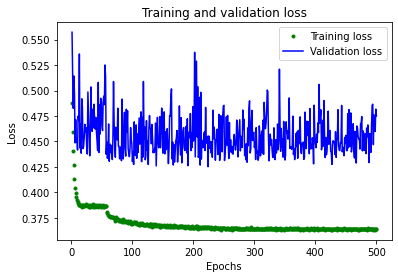

In [58]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean squared error_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss rapidly decreases over the first 25 epochs, before flattening out. This means that the model is improving and producing more accurate predictions!

Our goal is to stop training when either the model is no longer improving, or when the _training loss_ is less than the _validation loss_, which would mean that the model has learned to predict the training data so well that it can no longer generalize to new data.

To make the flatter part of the graph more readable, let's skip the first 50 epochs:

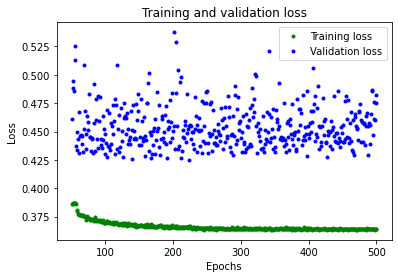

In [59]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the plot, we can see that loss continues to reduce until around 200 epochs, at which point it is mostly stable. This means that there's no need to train our network beyond 200 epochs.

However, we can also see that the lowest loss value is still around 0.155. This means that our network's predictions are off by an average of ~15%. In addition, the validation loss values jump around a lot, and is sometimes even higher.

**2. Mean Absolute Error**

To gain more insight into our model's performance we can plot some more data. This time, we'll plot the _mean absolute error_, which is another way of measuring how far the network's predictions are from the actual numbers:

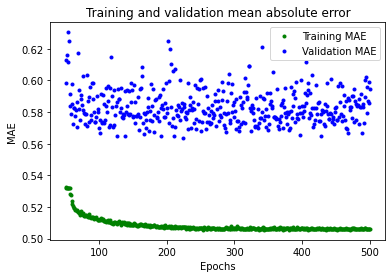

In [60]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

This graph of _mean absolute error_ tells another story. We can see that training data shows consistently lower error than validation data, which means that the network may have _overfit_, or learned the training data so rigidly that it can't make effective predictions about new data.

In addition, the mean absolute error values are quite high, ~0.305 at best, which means some of the model's predictions are at least 30% off. A 30% error means we are very far from accurately modelling the sine wave function.

**3. Actual vs Predicted Outputs**

To get more insight into what is happening, let's check its predictions against the test dataset we set aside earlier:

431/431 [==============================] - 0s 804us/step - loss: 0.3874 - mae: 0.5217


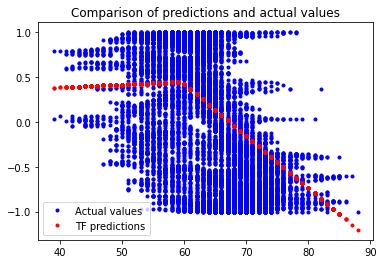

In [61]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

Oh dear! The graph makes it clear that our network has learned to approximate the sine function in a very limited way.

The rigidity of this fit suggests that the model does not have enough capacity to learn the full complexity of the sine wave function, so it's only able to approximate it in an overly simplistic way. By making our model bigger, we should be able to improve its performance.

## Training a Larger Model

### 1. Design the Model
To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with 16 neurons in the first layer and an additional layer of 16 neurons in the middle:

In [62]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

### 2. Train the Model ###

We'll now train and save the new model.

In [63]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/500
646/646 [==============================] - 1s 1ms/step - loss: 187.5449 - mae: 5.4852 - val_loss: 0.5584 - val_mae: 0.6765
Epoch 2/500
646/646 [==============================] - 1s 1ms/step - loss: 0.4592 - mae: 0.6029 - val_loss: 0.5502 - val_mae: 0.6730
Epoch 3/500
646/646 [==============================] - 1s 1ms/step - loss: 0.4584 - mae: 0.6024 - val_loss: 0.5491 - val_mae: 0.6722
Epoch 4/500
646/646 [==============================] - 1s 1ms/step - loss: 0.4570 - mae: 0.6016 - val_loss: 0.5481 - val_mae: 0.6714
Epoch 5/500
646/646 [==============================] - 1s 1ms/step - loss: 0.4551 - mae: 0.5999 - val_loss: 0.5525 - val_mae: 0.6727
Epoch 6/500
646/646 [==============================] - 1s 1ms/step - loss: 0.4525 - mae: 0.5978 - val_loss: 0.5232 - val_mae: 0.6588
Epoch 7/500
646/646 [==============================] - 1s 1ms/step - loss: 0.4490 - mae: 0.5954 - val_loss: 0.5517 - val_mae: 0.6706
Epoch 8/500
646/646 [==============================] - 1s 1ms/step 

646/646 [==============================] - 1s 857us/step - loss: 0.3897 - mae: 0.5366 - val_loss: 0.4350 - val_mae: 0.5830
Epoch 63/500
646/646 [==============================] - 1s 856us/step - loss: 0.3882 - mae: 0.5356 - val_loss: 0.4890 - val_mae: 0.6151
Epoch 64/500
646/646 [==============================] - 1s 853us/step - loss: 0.3885 - mae: 0.5349 - val_loss: 0.4461 - val_mae: 0.5917
Epoch 65/500
646/646 [==============================] - 1s 856us/step - loss: 0.3873 - mae: 0.5340 - val_loss: 0.4693 - val_mae: 0.6040
Epoch 66/500
646/646 [==============================] - 1s 863us/step - loss: 0.3892 - mae: 0.5348 - val_loss: 0.4730 - val_mae: 0.6073
Epoch 67/500
646/646 [==============================] - 1s 846us/step - loss: 0.3888 - mae: 0.5342 - val_loss: 0.4375 - val_mae: 0.5863
Epoch 68/500
646/646 [==============================] - 1s 937us/step - loss: 0.3877 - mae: 0.5341 - val_loss: 0.4563 - val_mae: 0.5977
Epoch 69/500
646/646 [==============================] - 1s 1m

646/646 [==============================] - 1s 2ms/step - loss: 0.3823 - mae: 0.5278 - val_loss: 0.4550 - val_mae: 0.5917
Epoch 123/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3801 - mae: 0.5252 - val_loss: 0.4662 - val_mae: 0.5973
Epoch 124/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3796 - mae: 0.5237 - val_loss: 0.4554 - val_mae: 0.5902
Epoch 125/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3780 - mae: 0.5221 - val_loss: 0.4767 - val_mae: 0.6014
Epoch 126/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3772 - mae: 0.5207 - val_loss: 0.4509 - val_mae: 0.5849
Epoch 127/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3753 - mae: 0.5185 - val_loss: 0.4777 - val_mae: 0.5986
Epoch 128/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3762 - mae: 0.5193 - val_loss: 0.4563 - val_mae: 0.5882
Epoch 129/500
646/646 [==============================] - 1s 1ms/step 

646/646 [==============================] - 1s 1ms/step - loss: 0.3535 - mae: 0.4931 - val_loss: 0.4252 - val_mae: 0.5606
Epoch 183/500
646/646 [==============================] - 1s 953us/step - loss: 0.3536 - mae: 0.4936 - val_loss: 0.4422 - val_mae: 0.5712
Epoch 184/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3523 - mae: 0.4919 - val_loss: 0.4230 - val_mae: 0.5620
Epoch 185/500
646/646 [==============================] - 1s 944us/step - loss: 0.3521 - mae: 0.4919 - val_loss: 0.4294 - val_mae: 0.5657
Epoch 186/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3530 - mae: 0.4923 - val_loss: 0.4219 - val_mae: 0.5583
Epoch 187/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3515 - mae: 0.4917 - val_loss: 0.4624 - val_mae: 0.5793
Epoch 188/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3517 - mae: 0.4911 - val_loss: 0.4406 - val_mae: 0.5656
Epoch 189/500
646/646 [==============================] - 1s 1ms/s

Epoch 243/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3490 - mae: 0.4886 - val_loss: 0.4229 - val_mae: 0.5642
Epoch 244/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3497 - mae: 0.4893 - val_loss: 0.4367 - val_mae: 0.5703
Epoch 245/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3481 - mae: 0.4878 - val_loss: 0.4522 - val_mae: 0.5731
Epoch 246/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3480 - mae: 0.4879 - val_loss: 0.4237 - val_mae: 0.5579
Epoch 247/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3494 - mae: 0.4889 - val_loss: 0.4241 - val_mae: 0.5630
Epoch 248/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3489 - mae: 0.4887 - val_loss: 0.4675 - val_mae: 0.5814
Epoch 249/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3495 - mae: 0.4892 - val_loss: 0.4408 - val_mae: 0.5714
Epoch 250/500
646/646 [==============================] 

646/646 [==============================] - 1s 1ms/step - loss: 0.3476 - mae: 0.4870 - val_loss: 0.4490 - val_mae: 0.5731
Epoch 304/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3486 - mae: 0.4880 - val_loss: 0.4251 - val_mae: 0.5632
Epoch 305/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3471 - mae: 0.4865 - val_loss: 0.4452 - val_mae: 0.5722
Epoch 306/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3485 - mae: 0.4876 - val_loss: 0.4202 - val_mae: 0.5582
Epoch 307/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3479 - mae: 0.4872 - val_loss: 0.4357 - val_mae: 0.5611
Epoch 308/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3468 - mae: 0.4860 - val_loss: 0.4428 - val_mae: 0.5713
Epoch 309/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3469 - mae: 0.4861 - val_loss: 0.4388 - val_mae: 0.5699
Epoch 310/500
646/646 [==============================] - 1s 2ms/step 

Epoch 364/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3475 - mae: 0.4870 - val_loss: 0.4234 - val_mae: 0.5605
Epoch 365/500
646/646 [==============================] - ETA: 0s - loss: 0.3476 - mae: 0.486 - 1s 1ms/step - loss: 0.3474 - mae: 0.4868 - val_loss: 0.4256 - val_mae: 0.5621
Epoch 366/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3470 - mae: 0.4863 - val_loss: 0.4199 - val_mae: 0.5595
Epoch 367/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3480 - mae: 0.4870 - val_loss: 0.4429 - val_mae: 0.5693
Epoch 368/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3468 - mae: 0.4860 - val_loss: 0.4385 - val_mae: 0.5652
Epoch 369/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3465 - mae: 0.4851 - val_loss: 0.4292 - val_mae: 0.5609
Epoch 370/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3466 - mae: 0.4852 - val_loss: 0.4342 - val_mae: 0.5684
Epoch 371/500
646

646/646 [==============================] - 1s 1ms/step - loss: 0.3460 - mae: 0.4855 - val_loss: 0.4297 - val_mae: 0.5610
Epoch 425/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3462 - mae: 0.4859 - val_loss: 0.4330 - val_mae: 0.5603
Epoch 426/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3463 - mae: 0.4853 - val_loss: 0.4299 - val_mae: 0.5630
Epoch 427/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3459 - mae: 0.4848 - val_loss: 0.4227 - val_mae: 0.5629
Epoch 428/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3469 - mae: 0.4860 - val_loss: 0.4199 - val_mae: 0.5582
Epoch 429/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3474 - mae: 0.4867 - val_loss: 0.4261 - val_mae: 0.5619
Epoch 430/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3467 - mae: 0.4857 - val_loss: 0.4491 - val_mae: 0.5728
Epoch 431/500
646/646 [==============================] - 1s 1ms/step 

646/646 [==============================] - 1s 924us/step - loss: 0.3461 - mae: 0.4859 - val_loss: 0.4511 - val_mae: 0.5739
Epoch 485/500
646/646 [==============================] - 1s 919us/step - loss: 0.3466 - mae: 0.4855 - val_loss: 0.4487 - val_mae: 0.5740
Epoch 486/500
646/646 [==============================] - 1s 871us/step - loss: 0.3466 - mae: 0.4855 - val_loss: 0.4428 - val_mae: 0.5704
Epoch 487/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3461 - mae: 0.4852 - val_loss: 0.4330 - val_mae: 0.5645
Epoch 488/500
646/646 [==============================] - 1s 2ms/step - loss: 0.3456 - mae: 0.4848 - val_loss: 0.4175 - val_mae: 0.5546
Epoch 489/500
646/646 [==============================] - ETA: 0s - loss: 0.3459 - mae: 0.485 - 1s 1ms/step - loss: 0.3464 - mae: 0.4859 - val_loss: 0.4350 - val_mae: 0.5663
Epoch 490/500
646/646 [==============================] - 1s 1ms/step - loss: 0.3459 - mae: 0.4852 - val_loss: 0.4268 - val_mae: 0.5608
Epoch 491/500
646/646 [==

### 3. Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 500/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0882 - val_loss: 0.0115 - val_mae: 0.0865
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.01, and validation MAE has dropped from 0.33 to 0.08.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

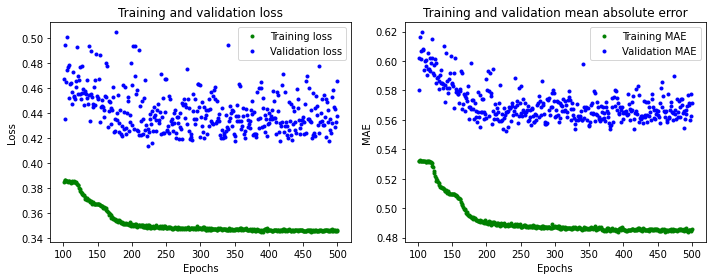

In [67]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Great results! From these graphs, we can see several exciting things:

*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


431/431 [==============================] - 0s 827us/step - loss: 0.3503 - mae: 0.4877


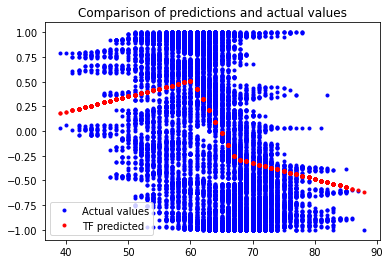

In [68]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well.

The model isn't perfect; its predictions don't form a smooth sine curve. For instance, the line is almost straight when `x` is between 4.2 and 5.2. If we wanted to go further, we could try further increasing the capacity of the model, perhaps using some techniques to defend from overfitting.

However, an important part of machine learning is *knowing when to stop*. This model is good enough for our use case - which is to make some LEDs blink in a pleasing pattern.

## Generate a TensorFlow Lite Model

### 1. Generate Models with or without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of a model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, we'll convert the model twice: once with quantization, once without.

In [69]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

3200

### 2. Compare Model Performance

To prove these models are accurate even after conversion and quantization, we'll compare their predictions and loss on our test dataset.

**Helper functions**

We define the `predict` (for predictions) and `evaluate` (for loss) functions for TFLite models. *Note: These are already included in a TF model, but not in  a TFLite model.*

In [70]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Predictions**

In [71]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

AttributeError: 'Series' object has no attribute 'reshape'

NameError: name 'y_test_pred_no_quant_tflite' is not defined

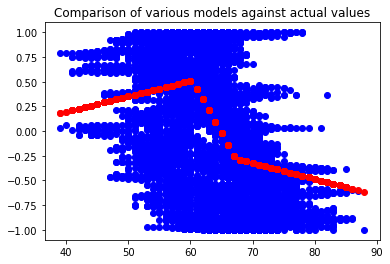

In [72]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

**2. Loss (MSE/Mean Squared Error)**

In [73]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

AttributeError: 'Series' object has no attribute 'reshape'

In [74]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

NameError: name 'loss_no_quant_tflite' is not defined

**3. Size**

In [75]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [76]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,3172 bytes,(reduced by 924 bytes)
TensorFlow Lite Quantized,3200 bytes,(reduced by -28 bytes)


**Summary**

We can see from the predictions (graph) and loss (table) that the original TF model, the TFLite model, and the quantized TFLite model are all close enough to be indistinguishable - even though they differ in size (table). This implies that the quantized (smallest) model is ready to use!

*Note: The quantized (integer) TFLite model is just 300 bytes smaller than the original (float) TFLite model - a tiny reduction in size! This is because the model is already so small that quantization has little effect. Complex models with more weights, can have upto a 4x reduction in size!*

## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [78]:
# Install xxd if it is not available
#!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

## Deploy to a Microcontroller

Follow the instructions in the [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) to deploy this model on a specific microcontroller.

**Reference Model:** If you have not modified this notebook, you can follow the instructions as is, to deploy the model. Refer to the [`hello_world/train/models`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/models) directory to access the models generated in this notebook.

**New Model:** If you have generated a new model, then update the values assigned to the variables defined in [`hello_world/model.cc`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/model.cc) with values displayed after running the following cell.

In [79]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x12, 0x00, 0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x0c, 0x0c, 0x00, 0x00, 0x14, 0x03, 0x00, 0x00,
  0xfc, 0x02, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x0b, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x6f, 0x6e, 0x00, 0x0c, 0x00, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00,
  0x94, 0x02, 0x00, 0x00, 0x38, 0x02, 0x00, 0x00, 0xd4, 0x01, 0x00, 0x00,
  0xc0, 0x01, 0x00, 0x00, 0x9c, 0x01, 0x00, 0x00, 0x88, 0x00, 0x00, 0x00,
  0x64, 0x00, 0x00, 0x00, 0x58, 0x00, 0x00, 0x00, 0x44, 0x00, 0x00, 0x00,
  0x30, 0x